In [1]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

from scipy import stats

from sklearn.datasets import load_digits

from sde.sde_learning_network import \
    (
        SDEIdentification,
        SDEIntegrators,
        ModelBuilder,
        WassersteinSDEModel,
        euler_maruyama_sampler,
        FrequentistModel,
        GPModelSimple,
        EMSamplerModel,
        VAEModelEncoding,
        LossAndErrorPrintingCallback,
        PreTrain
    )

from sde.experiment_reports import *

In [10]:
# notebook parameters
random_seed = 3
step_size = np.array(1e-6)
n_pts = 20000

n_layers = 1
n_dim_per_layer = 80

n_latent_dim = 32

LEARNING_RATE = 5e-3
VALIDATION_SPLIT = .05
BATCH_SIZE = 256
N_EPOCHS = 100
ACTIVATION = tf.nn.elu

tf.random.set_seed(random_seed)

In [11]:
# load dataset and create random x_data

rng = np.random.default_rng(random_seed)

y_data, y_labels = load_digits(return_X_y=True)
x_data = y_data + rng.normal(loc=0, scale=step_size, size=y_data.shape)

image_shape = (8,8)

n_dimensions = x_data.shape[1]

print('data shape', x_data.shape)
print('data shape', y_data.shape)

data shape (1797, 64)
data shape (1797, 64)


In [12]:
# define the neural network model we will use for identification
model = ModelBuilder.define_gaussian_process(n_dimensions, n_dimensions,
                                             n_layers=n_layers,
                                             n_dim_per_layer=n_dim_per_layer,
                                             name="gaussianprocess",
                                             dtype=tf.float64,
                                             activation=ACTIVATION)

model.summary()


Model: "gaussianprocess_gaussian_process"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gaussianprocess_inputs (InputLa [(None, 64)]         0                                            
__________________________________________________________________________________________________
gaussianprocess_mean_hidden_0 ( (None, 80)           5200        gaussianprocess_inputs[0][0]     
__________________________________________________________________________________________________
gaussianprocess_std_hidden_0 (D (None, 80)           5200        gaussianprocess_inputs[0][0]     
__________________________________________________________________________________________________
gaussianprocess_output_mean (De (None, 64)           5184        gaussianprocess_mean_hidden_0[0][
___________________________________________________________________

In [16]:
model_type = "Wasserstein"

#model = FrequentistModel(model, step_size = step_size)
#model_sde = GPModelSimple(model, step_size=step_size)
#model_sde = EMSamplerModel(model, step_size=step_size)
#model_sde = FrequentistModel(model, step_size = step_size)

if model_type == "Wasserstein":
    model_sde = WassersteinSDEModel(model, step_size = step_size, kernel_scale=5e-2)
    

if model_type=="VAE":
    model, decoder, full_model = VAEModelEncoding.define_model(n_dimensions,
                                                          n_latent_dim,
                                                          n_layers,
                                                          n_dim_per_layer,
                                                          activation=ACTIVATION,
                                                          use_diag_std=True)
    model_sde = VAEModelEncoding(encoder=model,
                                 decoder=decoder,
                                 step_size=step_size, # will be given during training
                                 use_diag_std=True)


In [17]:
initial_learning_rate = LEARNING_RATE
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.95,
    staircase=True)
model_sde.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule))
sde_i = SDEIdentification(model=model_sde)

hist = sde_i.train_model(x_data, y_data,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size = BATCH_SIZE*1)

training for 100 epochs with 1707 data points, validating with 89
The average loss for epoch 99 is 63.7157087102 806 

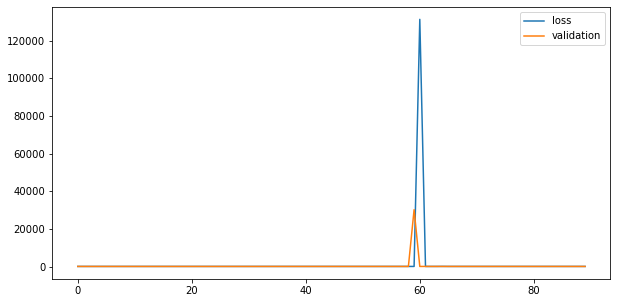

In [18]:
delay = 10

fig,hist_axes = plt.subplots(1,1,figsize=(10,5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"][delay:], label='loss')
hist_axes.plot(hist.history["val_loss"][delay:], label='validation')
hist_axes.legend()

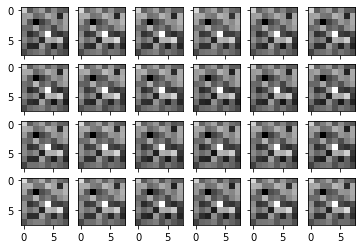

In [21]:
# show generated digits

x_data_test = x_data[:100,:]#rng.normal(loc=0, scale=1, size=(4*6, x_data.shape[1]))

images, _ = sde_i.drift_diffusivity(x_data_test)

idx = 0
fig,ax = plt.subplots(4,6,sharex=True,sharey=True)
for k1 in range(ax.shape[0]):
    for k2 in range(ax.shape[1]):
        ax[k1,k2].imshow(images[idx,:].reshape(image_shape), cmap="gray")
        idx += 1

In [20]:
# plot the latent space of the VAE model

if model_type=="VAE":
    latent_space = keras.backend.eval(model(x_data)[0])

    fig,ax=plt.subplots(1,1,figsize=(6,6))
    ax.scatter(*latent_space[:,:2].T, s=10, c=y_labels,label="labels")
    ax.set_xlabel("latent 1")
    ax.set_ylabel("latent 2")
    ax.legend()
    fig.tight_layout()